# Proyecto: Análisis de mercado inmobiliario + Ingenieria de features y modelos avanzados.

Aplica transformación de datos y entrena Modelos Avanzados para desarrollar con mayor profundidad tu modelo de Machine Learning:
* En la Parte 1, Transformacion de datos.
* En la Parte 2, Modelos avanzados.
* En la Parte 3, Interpretacion de modelos.


En este proyecto vas a trabajar con un dataset de propiedades en venta publicado en el portal [Properati](www.properati.com.ar).



## Pipeline

### Parte 1, Transformacion de datos.

1. Transformacion de los datos:
    * Analisis de propiedades
    * Deteccion de nulls.
    * Imputacion de valores faltantes.
    * Eliminacion de instancias con datos contradictorios o poca cantidad de datos.


2. Detección y eliminación de Outliers:
   * Determinar outliers para Bathrooms y rooms
       * Regla de los 3 sigmas ( si no hay mucha varianza )
   * Para superficie total determinamos outliers con reglas de diseño.
   * Creamos un boxpolot con alguna propiedad
       * 3 box-plots


3. Encoding: transformamos las variables categoricas en numeros: barrio (l3) y tipo de propiedad.

4. Train-test.

5. Escalado de datos: todos los datos salvo el price.

6. Reduccion de dimensionalidad


### Parte 2, Modelos avanzados.

7. Benchmark: Ver Arbol de decision proyecto 1 y compararlo con proyecto 2. Usar los mismos hiperparametros.

8. Modelos de ensamble:
    * 



## 1. Transformacion de los datos.

En esta sección, Continuamos con el Análisis Exploratorio de Datos realizados en el proyecto 1. Debemos elegir cual de las siguientes tareas es apropiada para este dataset e implementar la transformacion

* Detección y eliminación de Outliers
* Encoding
* Imputación de valores faltantes
* Escalado de datos
* Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Importamos librerias utiles para trabajar.

In [1]:
# 1 Importar liberias utilesimport numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from scipy.stats import uniform, randint
import scipy as sp

Cargamos el Dataset. Si no se encuentra el dataset, descomprimir zip ubicado en /Datasets. Realizamos una aproximación al dataset, mostrando las primeros cinco instancias.

In [2]:
# 2. Cargar dataset, informacion general.
path = "Datasets/DS_Proyecto_01_Datos_Properati.csv"
dataset = pd.read_csv(path)
dataset.head()
dataset.shape

(146660, 19)

### 1.1 Analisis de propiedades

#### Rooms
* En Argentina, cuando se habla de un departamento 3 ambientes, significa que le departamento tiene tres espacios de permanencia, es decir, no contamos los espacios de serivicio como cocina, baño, lavadero o cochera.

* Descripcion obtenida del sitio web de properati:
    * rooms - Cantidad de ambientes (útil en Argentina).
    * bedrooms - Cantidad de dormitorios (útil en el resto de los países).
    * bathrooms - Cantidad de baños.
    
* Asumo que bathrooms no esta incluido en rooms, pero que bedrooms si lo esta, dado que en algunos casos bedrooms + bathrooms es mayor que rooms.

#### Reglas de diseño:  Estudiar anomalias referidas a la relacion entre algunas de las propiedades. 
* Que la superficie cubierta sea menor o igual a la superficie total.
* Una de las propiedades que presenta nulls son los baños. Quisiera estudiar mas detenidamente como se cargaron algunos valores. Tiene sentido que una propiedad de dos ambientes ( living-comedor + 1 dormitorio) tenga mas de dos baños? diría que no. Es poco común. De la misma manera. Tiene sentido que una propiedad de mas de 60m2 tenga solo 1 baño? Puede ser, en ambos casos, si hablamos de viviendas probablemente quien las diseño deberia replantearse cuanta gente habita cada lugar.
* Si un deposito presenta un dato null en baños o dormitorios. Debemos calcularlo o podemos inferirlo? sabemos que un deposito no tiene dormitorios, y dependiendo del diseño puede tener 1 o 2 baños. En que situacion un deposito podria tener mas de un baños?

#### Descartamos propiedades poco utiles para nuestro analisis
Primero descartamos aquellas propiedades que no son utiles para nuestro analisis y contamos la cantidad de datos faltantes por columna que tiene el dataset.

In [3]:
dataset.drop(['l1', 'lat','lon','start_date', 'end_date', 'created_on', 'title', 'currency','operation_type', 'description'], 'columns', inplace = True )
dataset.head(500)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH
...,...,...,...,...,...,...,...,...,...
495,Bs.As. G.B.A. Zona Sur,Berazategui,5.0,3.0,2.0,236.0,192.0,200000.0,Casa
496,Bs.As. G.B.A. Zona Sur,San Vicente,7.0,3.0,3.0,814.0,236.0,370000.0,Casa
497,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,6.0,3.0,2.0,266.0,170.0,225000.0,Casa
498,Bs.As. G.B.A. Zona Sur,Esteban Echeverría,5.0,3.0,2.0,938.0,180.0,280000.0,Casa


### 1.2 Deteccion de nulls

In [4]:
print("Nulls en cada columna:")
dataset.isna().sum()

Nulls en cada columna:


l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
property_type          0
dtype: int64

### 1.3 Imputacion de valores faltantes

In [5]:
#imputacion bathroom: regla de diseño.
def fill_bathroom(room_count):
    if (room_count < 3):
        return 1
    elif (room_count >= 3 and room_count < 5):
        return 2
    elif (room_count >= 5 and room_count < 7):
        return 3
    elif (room_count >= 8 and room_count < 10):
        return 4
    else:
        return 5

a = 0
for row in dataset.index:
    if(np.isnan(dataset['bathrooms'][row])):
        dataset['bathrooms'][row] = fill_bathroom(dataset['rooms'][row])
        a=a+1

ds2 = dataset.copy()
ds2.isna().sum()
#print(a)

<ipython-input-5-cff293fb3bf1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['bathrooms'][row] = fill_bathroom(dataset['rooms'][row])


l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms              0
surface_total      20527
surface_covered    21614
price                  0
property_type          0
dtype: int64

### 1.4 Eliminacion de instancias con datos contradictorios

Eliminamos aquellas instancias que tienen:
   * Mayor superficie cubierta que superficie total
   * Mayor cantidad de baños que habitaciones
    

In [6]:
if not "_rooms" in ds2:
    ds2["_rooms"] = ds2["rooms"]-ds2["bedrooms"]

Checkpoint mas adelante si solo trabajamos con capital federal:

* Departamento    62723
* PH               9408
* Casa             1979

Muy pocas casas.

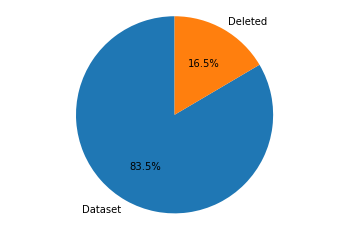

(122426, 10)

In [7]:
#Solo capital federal
#mask0 =(ds2["l2"]=="Capital Federal")

#sup cubierta mayor que sup total
mask1 = (ds2['surface_total'] >= ds2['surface_covered'])
  
#mas baños que habitaciones
mask2 = (ds2['rooms'] >= ds2['bathrooms'])

#ds3 = ds2[mask0 & mask1 & mask2]
ds3 = ds2[mask1 & mask2]

d1 = ds3.shape[0]
d2 = ds2.shape[0] - ds3.shape[0]

labels = ['Dataset', 'Deleted']
sizes = [d1, d2]  # Add upto 100%
 
# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
 
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
 
# Display the graph onto the screen
plt.show()

ds3.shape

In [8]:
ds2.isna().sum()
ds3.isna().sum()


l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
_rooms             0
dtype: int64

In [9]:
pd.unique(ds3.loc[:,'property_type'])

array(['Departamento', 'PH', 'Casa', 'Casa de campo', 'Oficina', 'Lote',
       'Otro', 'Local comercial', 'Cochera', 'Depósito'], dtype=object)

In [10]:
#Propiedades que solo tienen bethrooms y bathrooms?
mask4 = (ds3['_rooms'] > 0 | ds3['_rooms'].isna())

#Propiedades que no tienen bedrooms? -> Monoambientes
monoambientes= (ds3['bedrooms'].isna())
print("Monoambientes: " + str(monoambientes.sum()) + " Casos")

mask5 = ((ds3['property_type'] == "PH") | (ds3['property_type'] == "Departamento") | (ds3['property_type'] == "Casa"))

ds4 = ds3[mask4 & mask5]

Monoambientes: 0 Casos


In [11]:
ds4.isnull().sum()
ds4.head()
ds4.shape[0]

113233

Podemos analizar la relacion que existe entre las variables surface_total y surface_covered.

Las eliminamos, no tiene mucho sentido mantenerlas o suponer algun valor.

#### Correlacion entre las variables

In [12]:
corr = ds4.corr()

<AxesSubplot:>

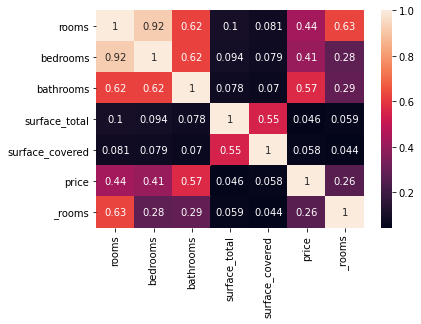

In [13]:
sns.heatmap(corr, cbar = True, annot = True )

#### Determinacion de Outliers

In [14]:
ds4.property_type.value_counts()

Departamento    83950
Casa            15617
PH              13666
Name: property_type, dtype: int64

In [15]:
def set_outliers(p):
    ceil = p.mean()+3*(p.std())
    floor = p.mean()-3*(p.std())
    print("Max value: ", ceil)
    print("Min value: ", floor)
    print("The rest is not common")

In [16]:
deptos = ds4[ds4.property_type=="Departamento"]
set_outliers(deptos.bathrooms)
set_outliers(deptos.rooms)
set_outliers(deptos.surface_covered)
set_outliers(deptos.price)

Max value:  3.8703190499756097
Min value:  -0.7977758695110471
The rest is not common
Max value:  6.124998434394097
Min value:  -0.22196091205937352
The rest is not common
Max value:  1431.3684017838773
Min value:  -1263.1104387106193
The rest is not common
Max value:  1109073.4488752396
Min value:  -607339.7834076993
The rest is not common


En ninguno de estos casos tendremos valores negativos. Los limites inferiores se re definen de la siguiente manera:
* Cantidad minima de baños : 1
* Cantidad minima de rooms : 1
* Superficie minima : 35m2
* Precio minimo : 20 mil dolares

Los valores arrojados para surface_covered no son aceptables. Se determina como valor maximo 300m2

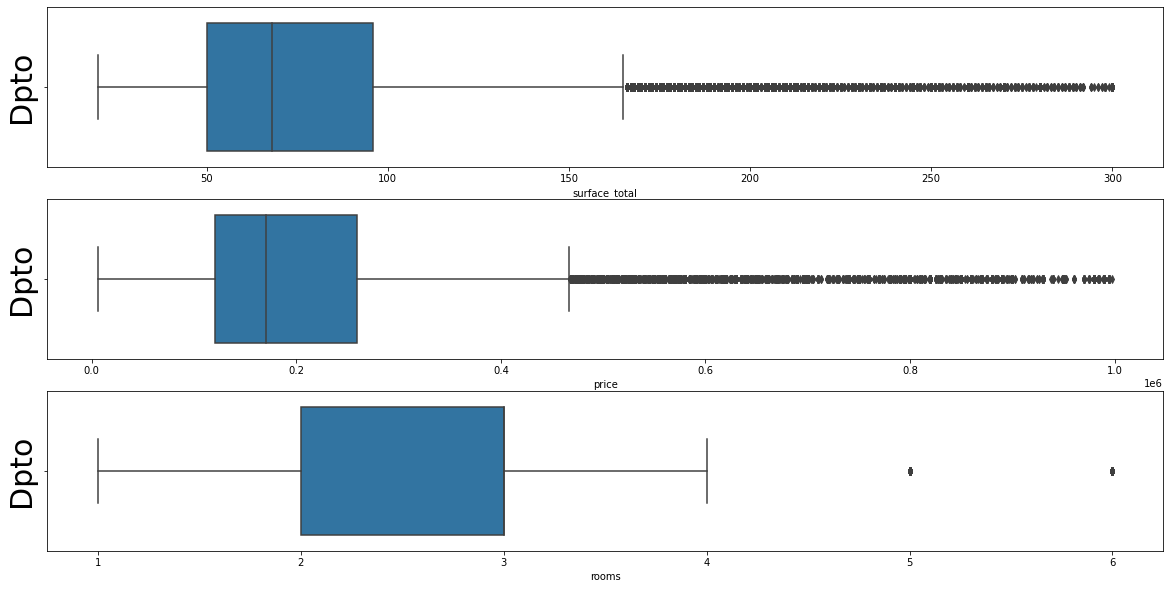

In [17]:
dptos_mask= ((ds4['property_type']=='Departamento')&
            (ds4['bathrooms']<=4)&
            (ds4['rooms'] <=6)&
            (ds4['surface_total']<=300)&
            (ds4['surface_total']>=20)&
            (ds4['price']<1000000))

plt.figure(figsize=(20, 10))

plt.subplot(3,1,1)
sns.boxplot(data = ds4[dptos_mask], x = 'surface_total')
plt.ylabel('Dpto', size = 30)

plt.subplot(3,1,2)
sns.boxplot(data = ds4[dptos_mask], x = 'price')
plt.ylabel('Dpto', size = 30)

plt.subplot(3,1,3)
sns.boxplot(data = ds4[dptos_mask], x = 'rooms')
plt.ylabel('Dpto', size = 30)

corr_dpto=ds4[dptos_mask].corr()

In [18]:
casas = ds4[ds4.property_type=="Casa"]
print("Bathrooms")
set_outliers(casas.bathrooms)
print("--------")
print("Rooms")
set_outliers(casas.rooms)
print("--------")
print("Surface covered")
set_outliers(casas.surface_covered)
print("--------")
print("Price")
set_outliers(casas.price)

Bathrooms
Max value:  5.3365610006226
Min value:  -1.1338332039907253
The rest is not common
--------
Rooms
Max value:  9.17837199368896
Min value:  0.04106835977201051
The rest is not common
--------
Surface covered
Max value:  3280.043025487179
Min value:  -2845.964393227462
The rest is not common
--------
Price
Max value:  1101338.277953481
Min value:  -555694.1816481727
The rest is not common


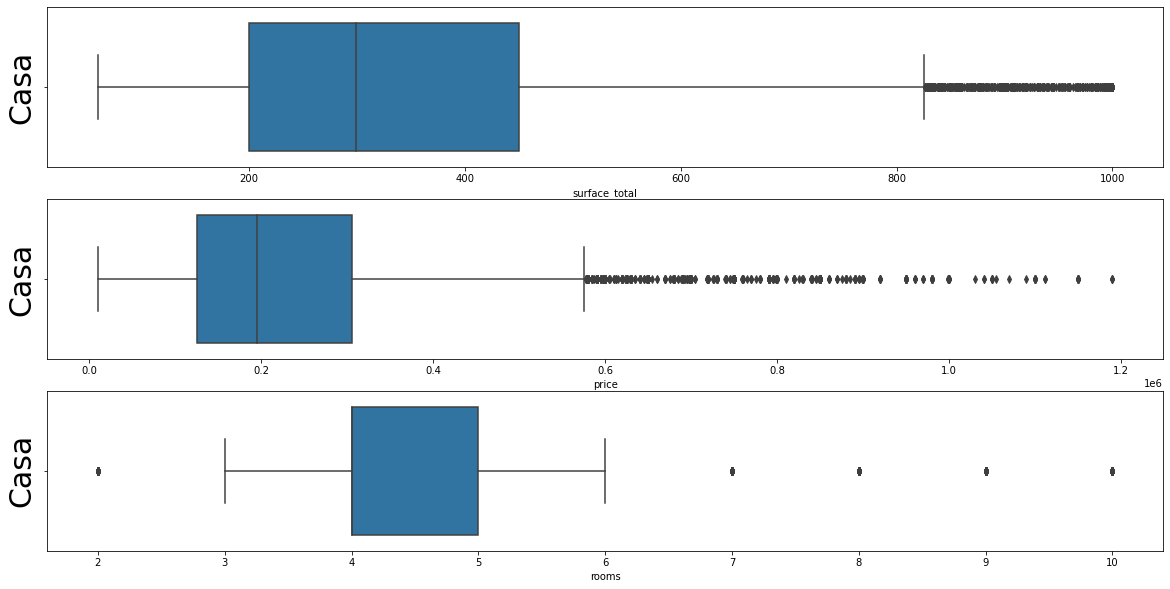

In [19]:
casa_mask= ((ds4['property_type']=='Casa')&
            (ds4['bathrooms']<=6)&
            (ds4['rooms']<=10)&
            (ds4['surface_total']<=1000)&
            (ds4['surface_total']>=60)&
            (ds4['price']<1200000))

plt.figure(figsize=(20, 10))

plt.subplot(3,1,1)
sns.boxplot(data = ds4[casa_mask], x = 'surface_total')
plt.ylabel('Casa', size = 30)

plt.subplot(3,1,2)
sns.boxplot(data = ds4[casa_mask], x = 'price')
plt.ylabel('Casa', size = 30)

plt.subplot(3,1,3)
sns.boxplot(data = ds4[casa_mask], x = 'rooms')
plt.ylabel('Casa', size = 30)

corr_dpto=ds4[casa_mask].corr()

In [20]:
phs = ds4[ds4.property_type=="PH"]
print("Bathrooms")
set_outliers(phs.bathrooms)
print("--------")
print("Rooms")
set_outliers(phs._rooms)
print("--------")
print("Surface covered")
set_outliers(phs.surface_covered)
print("--------")
print("Price")
set_outliers(phs.price)

Bathrooms
Max value:  3.6853264809502875
Min value:  -0.7109374863651858
The rest is not common
--------
Rooms
Max value:  2.7877003295583567
Min value:  -0.5059792699944758
The rest is not common
--------
Surface covered
Max value:  4734.6854143216815
Min value:  -4498.409547206212
The rest is not common
--------
Price
Max value:  528922.8386300481
Min value:  -148598.12035110762
The rest is not common


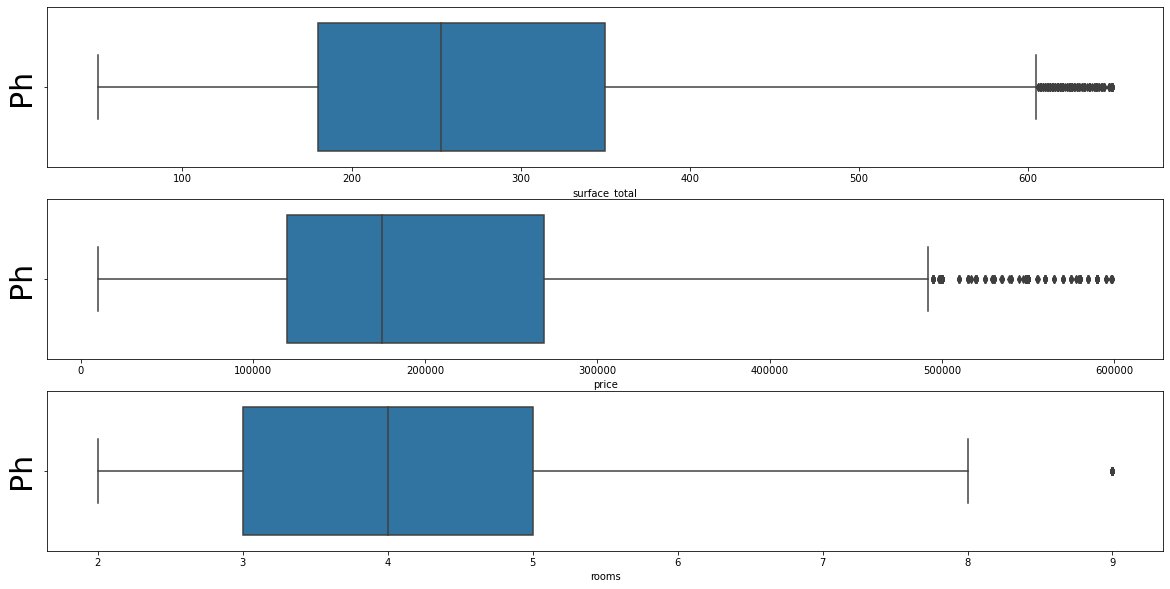

In [21]:
phs_mask= ((ds4['property_type']=='Casa')&
            (ds4['bathrooms']<=4)&
            (ds4['rooms']<=9)&
            (ds4['surface_total']<=650)&
            (ds4['surface_total']>=50)&
            (ds4['price']<600000))

plt.figure(figsize=(20, 10))

plt.subplot(3,1,1)
sns.boxplot(data = ds4[phs_mask], x = 'surface_total')
plt.ylabel('Ph', size = 30)

plt.subplot(3,1,2)
sns.boxplot(data = ds4[phs_mask], x = 'price')
plt.ylabel('Ph', size = 30)

plt.subplot(3,1,3)
sns.boxplot(data = ds4[phs_mask], x = 'rooms')
plt.ylabel('Ph', size = 30)

corr_dpto=ds4[phs_mask].corr()

### Encoding

In [22]:
#enc = LabelEncoder()
#l3_labels = enc.fit_transform(ds4["l3"])
#ds4.insert(7,"Enc_Barrio",l3_labels)
#ds4.head()

enc_l3 = pd.get_dummies(ds4.l3, drop_first=True)

pca3=PCA(n_components=25)
_pca3 = pca3.fit_transform(enc_l3.loc[:])
a = pd.DataFrame(_pca3)
a.index = ds4.index
ds4 = pd.concat([ds4, a], axis=1)
ds4.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,_rooms,...,15,16,17,18,19,20,21,22,23,24
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,1.0,...,0.019089,-0.046341,-0.022847,0.010408,-0.027693,0.010672,-0.001647,-0.039302,-0.056498,0.020405
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,1.0,...,-0.002162,0.007877,0.002887,0.000757,0.000819,-0.000738,-0.002175,0.001795,0.001181,0.000117
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,1.0,...,-0.002162,0.007877,0.002887,0.000757,0.000819,-0.000738,-0.002175,0.001795,0.001181,0.000117
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH,1.0,...,-0.014293,0.046946,0.015529,0.003876,0.004126,-0.003710,-0.010634,0.008529,0.005509,0.000546
5,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,1.0,...,-0.005684,0.020084,0.007119,0.001835,0.001974,-0.001778,-0.005191,0.004238,0.002772,0.000273


In [23]:
pca3.explained_variance_ratio_

array([0.0978219 , 0.06985314, 0.05767654, 0.05062518, 0.0489998 ,
       0.04675228, 0.03949072, 0.0303944 , 0.02747846, 0.02594232,
       0.02496879, 0.02338357, 0.02151235, 0.01972353, 0.01886741,
       0.01814076, 0.01644051, 0.01446074, 0.01334994, 0.01314398,
       0.01289894, 0.01236105, 0.01181094, 0.01132019, 0.01101902])

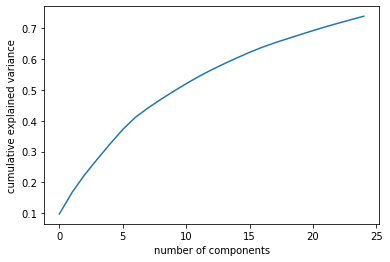

In [24]:
plt.plot(np.cumsum(pca3.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [40]:
enc_property_type = pd.get_dummies(ds4.property_type, drop_first= True)
enc_property_type.index = ds4.index
enc_property_type.head()

,Departamento,PH
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1


In [41]:
ds4.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,_rooms,...,15,16,17,18,19,20,21,22,23,24
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,1.0,...,0.019089,-0.046341,-0.022847,0.010408,-0.027693,0.010672,-0.001647,-0.039302,-0.056498,0.020405
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,1.0,...,-0.002162,0.007877,0.002887,0.000757,0.000819,-0.000738,-0.002175,0.001795,0.001181,0.000117
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,1.0,...,-0.002162,0.007877,0.002887,0.000757,0.000819,-0.000738,-0.002175,0.001795,0.001181,0.000117
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH,1.0,...,-0.014293,0.046946,0.015529,0.003876,0.004126,-0.003710,-0.010634,0.008529,0.005509,0.000546
5,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,1.0,...,-0.005684,0.020084,0.007119,0.001835,0.001974,-0.001778,-0.005191,0.004238,0.002772,0.000273


In [42]:
ds4.drop("l2", axis = 1, inplace = True)
ds4.drop("l3", axis = 1, inplace = True)
ds4.drop("property_type", axis = 1, inplace = True)
ds4 = pd.concat([ds4, enc_property_type], axis=1)
ds4.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,_rooms,0,1,2,...,17,18,19,20,21,22,23,24,Departamento,PH
1,2.0,1.0,2.0,70.0,58.0,159000.0,1.0,-0.065357,-0.044255,-0.033373,...,-0.022847,0.010408,-0.027693,0.010672,-0.001647,-0.039302,-0.056498,0.020405,0,1
2,2.0,1.0,1.0,45.0,45.0,125000.0,1.0,0.907441,0.081461,0.036813,...,0.002887,0.000757,0.000819,-0.000738,-0.002175,0.001795,0.001181,0.000117,0,1
3,2.0,1.0,1.0,85.0,50.0,295000.0,1.0,0.907441,0.081461,0.036813,...,0.002887,0.000757,0.000819,-0.000738,-0.002175,0.001795,0.001181,0.000117,0,1
4,2.0,1.0,1.0,50.0,35.0,40000.0,1.0,-0.089832,-0.072863,-0.065017,...,0.015529,0.003876,0.004126,-0.003710,-0.010634,0.008529,0.005509,0.000546,0,1
5,2.0,1.0,1.0,56.0,56.0,150000.0,1.0,-0.127674,-0.148980,-0.255971,...,0.007119,0.001835,0.001974,-0.001778,-0.005191,0.004238,0.002772,0.000273,0,1


#### Separacion de los datos

In [43]:
X=ds4.drop(("price"), axis=1)
y=ds4.price

X_Train, X_Test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

#### Escalado de los datos

In [44]:
#Separamos aquellos datos no numericos.
train_features = X_Train.loc[:,[ "bedrooms", "bathrooms", "surface_total", "surface_covered","rooms"]]
test_features = X_Test.loc[:,["bedrooms", "bathrooms", "surface_total", "surface_covered","rooms"]]

In [45]:
Scaler = MinMaxScaler()

In [46]:
train_features_scaled = Scaler.fit_transform(train_features)
test_features_scaled = Scaler.transform(test_features)

In [47]:
X_Train.loc[:,train_features.columns] = train_features_scaled
X_Test.loc[:,test_features.columns] = test_features_scaled

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [48]:
X_Train.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,_rooms,0,1,2,3,...,17,18,19,20,21,22,23,24,Departamento,PH
131535,0.088235,0.200000,0.000000,0.012059,0.000785,1.0,-0.066206,-0.045090,-0.034276,-0.005896,...,-0.025878,0.007176,-0.006285,0.003685,0.039931,-0.019657,-0.057086,0.038746,0,0
3163,0.088235,0.200000,0.083333,0.001253,0.001237,1.0,-0.125679,-0.143338,-0.230470,-0.617850,...,0.007266,0.001871,0.002014,-0.001814,-0.005294,0.004320,0.002824,0.000278,1,0
18247,0.058824,0.133333,0.000000,0.000460,0.000468,1.0,-0.066775,-0.045681,-0.034790,-0.006063,...,-0.057294,-0.029839,-0.013859,0.019993,0.052053,-0.044851,-0.014691,-0.036398,1,0
92053,0.058824,0.133333,0.000000,0.000397,0.000468,1.0,-0.072052,-0.051119,-0.040105,-0.007153,...,0.869727,0.055935,0.044789,-0.037774,-0.081604,0.055868,0.032554,0.003757,1,0
14130,0.088235,0.200000,0.000000,0.000682,0.000666,1.0,-0.127674,-0.148980,-0.255971,0.777407,...,0.007119,0.001835,0.001974,-0.001778,-0.005191,0.004238,0.002772,0.000273,1,0


#### Reduccion de dimensionalidad

In [49]:
pca=PCA(n_components = 3)
x_train_pca = pca.fit_transform(X_Train.loc[:,["rooms","bathrooms", "bedrooms"]])
x_test_pca = pca.fit_transform(X_Test.loc[:,["rooms","bathrooms", "bedrooms"]])
x_train_pca = pd.DataFrame(x_train_pca)
x_test_pca=  pd.DataFrame(x_test_pca)

In [50]:
x_train_pca.index=X_Train.index
x_test_pca.index=X_Test.index

In [51]:
pca.explained_variance_ratio_

array([0.80972099, 0.17645762, 0.01382139])

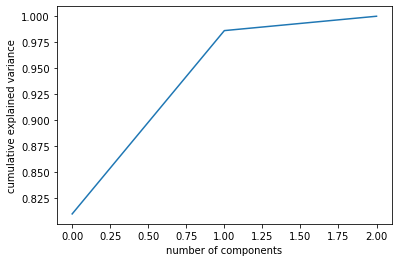

In [52]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

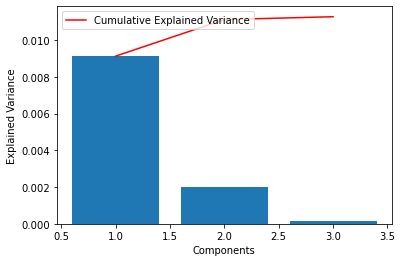

In [53]:
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ )
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

Por medio del grafico vemos que es conveniente reducir la cantidad de features a 2. Con dos componentes estamos explicando el 99% de la varianza de los datos.

In [54]:
pca2 = PCA(n_components=2)
x_train_pca2 = pca2.fit_transform(X_Train.loc[:,["rooms","bathrooms", "bedrooms"]])
x_test_pca2 = pca2.fit_transform(X_Test.loc[:,["rooms","bathrooms", "bedrooms"]])

In [55]:
x_train_pca2

array([[ 0.01544835,  0.0790962 ],
       [ 0.06879229,  0.01510196],
       [-0.0403908 ,  0.03243738],
       ...,
       [-0.09622995, -0.01422144],
       [ 0.06879229,  0.01510196],
       [-0.0403908 ,  0.03243738]])

In [56]:
x_train_pca2 = pd.DataFrame(x_train_pca2, columns=["a","b"])
x_test_pca2 =  pd.DataFrame(x_test_pca2, columns=["a","b"])

In [57]:
x_train_pca2.index=X_Train.index
x_test_pca2.index=X_Test.index

In [58]:
pca2.explained_variance_ratio_

array([0.80972099, 0.17645762])

In [59]:
X_Train = pd.concat([X_Train, x_train_pca2],axis=1)
X_Train.drop(["rooms","bathrooms", "bedrooms"],axis=1,inplace=True)

X_Test = pd.concat([X_Test, x_test_pca2],axis=1)
X_Test.drop(["rooms","bathrooms", "bedrooms"],axis=1,inplace=True)

In [60]:
X_Train

,surface_total,surface_covered,_rooms,0,1,2,3,4,5,6,...,19,20,21,22,23,24,Departamento,PH,a,b
131535,0.012059,0.000785,1.0,-0.066206,-0.045090,-0.034276,-0.005896,0.017426,0.016284,-0.092206,...,-0.006285,0.003685,0.039931,-0.019657,-0.057086,0.038746,0,0,0.015448,0.079096
3163,0.001253,0.001237,1.0,-0.125679,-0.143338,-0.230470,-0.617850,-0.594504,-0.185529,0.274870,...,0.002014,-0.001814,-0.005294,0.004320,0.002824,0.000278,1,0,0.068792,0.015102
18247,0.000460,0.000468,1.0,-0.066775,-0.045681,-0.034790,-0.006063,0.017621,0.016671,-0.094118,...,-0.013859,0.019993,0.052053,-0.044851,-0.014691,-0.036398,1,0,-0.040391,0.032437
92053,0.000397,0.000468,1.0,-0.072052,-0.051119,-0.040105,-0.007153,0.021024,0.020071,-0.119216,...,0.044789,-0.037774,-0.081604,0.055868,0.032554,0.003757,1,0,-0.040391,0.032437
14130,0.000682,0.000666,1.0,-0.127674,-0.148980,-0.255971,0.777407,-0.368291,-0.152691,0.257036,...,0.001974,-0.001778,-0.005191,0.004238,0.002772,0.000273,1,0,0.015448,0.079096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92683,0.002301,0.000412,1.0,-0.064469,-0.043413,-0.032660,-0.005605,0.016446,0.015346,-0.085462,...,-0.009091,0.004835,0.021182,-0.032336,0.003719,-0.014389,0,0,-0.040391,0.032437
143445,0.000286,0.000357,1.0,-0.240819,0.901996,0.112474,0.011457,-0.030028,-0.024470,0.088001,...,0.001248,-0.001125,-0.003303,0.002715,0.001782,0.000176,1,0,-0.096230,-0.014221
136468,0.000262,0.000309,1.0,-0.081465,-0.061903,-0.051663,-0.009752,0.029231,0.028668,-0.194886,...,0.006627,-0.005953,-0.016738,0.013104,0.008388,0.000822,1,0,-0.096230,-0.014221
959,0.005363,0.005434,1.0,-0.068949,-0.047863,-0.036896,-0.006433,0.018995,0.017930,-0.103610,...,-0.039164,0.033893,0.165825,-0.217156,-0.379833,-0.687119,0,0,0.068792,0.015102


#### Benchmark, comparacion con modelo anterior

Proyecto 1:
* Err Train: 131342.04481899692
* Err Test: 167547.23542405185

#### Ahora vamos a ver que error obtenemos luego de procesar los datos de otra manera

In [61]:
d_tree= DecisionTreeRegressor(max_depth = 10, random_state = 42)
d_tree.fit(X_Train,y_train)
train_predict=d_tree.predict(X_Train)
test_predict=d_tree.predict(X_Test)

In [62]:
def decision_tree(title, depths, X_train, X_test, Y_train, Y_test):
        #Define error list
        err_train = []
        err_test = []
        for depth in depths:
            
            #Define DesitionTreeRegresson and fit it
            a = DecisionTreeRegressor(max_depth = depth, random_state = 42)
            a.fit(X_train, Y_train)
            
            #try
            Y_train_pred = a.predict(X_train)
            train_err = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
            
            Y_test_pred = a.predict(X_test)
            test_err = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

            #save the error
            err_train.append(train_err)
            err_test.append(test_err)
         
        plt.plot(depths, err_train,'o-',label='train' )
        plt.plot(depths, err_test, 'o-',label='test')
        plt.legend()
        plt.title(title)
        plt.xlabel('depths')
        plt.ylabel('error')

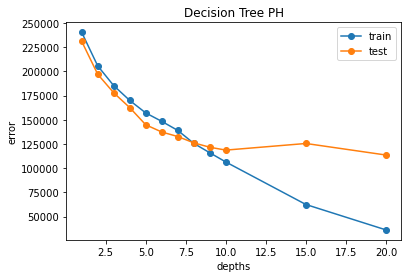

In [63]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
decision_tree('Decision Tree PH', depths, X_Train, X_Test, y_train, y_test)

In [64]:
train_rmse2= np.sqrt(mean_squared_error(train_predict, y_train))
test_rmse2= np.sqrt(mean_squared_error(test_predict, y_test))
print('El error del train prop es',train_rmse2)
print('El error del test prop es',test_rmse2)

El error del train prop es 106354.31869892083
El error del test prop es 118632.17912726122


#### Correccion: Se mejoro el benchmark, utilizando get_dummies en lugar de LabelEncoder:

    -Entrega anterior:
        -El error del train prop es 110412.85425653051
        -El error del test prop es 128826.01977657645

### Benchmark

Para realizar una comparacion con el trabajo anterior, reformule parte del proyecto. Esto se debe a que en principio habia subdividido los diferentes modelos en funcion del tipo de propiedad. Considero que para PH y Casas, la cantidad de propiedades resultantes es muy poca (8 mil para PH y 3 mil para Casas aprox) como para que el modelo tenga un entrenamiento correcto. Lo que hice fue reformular el modelo 1 y correr estos modelos sobre un solo dataset en lugar de 3. El proyecto 1 modificado se encuentra en el mismo repositorio que le proyecto 2.

### Modelos avanzados

Continuamos con al creacion de modelos avanzados, con el objetivo de disminuir aun mas el error del modelo que creamos. Creamos un nuevo modelo que utiliza como metodo de ensamble la tecnica baging y otro que ustiliza boosting.

* RandomForest - baging
* XGBoost - boosting

Primero utilizaremos los hiperparametros por defecto y luego elegiremos los mejores utilizando el metodo RandomizeSearchCV.

#### Utilizando Random Forest

In [65]:
ran_forest = RandomForestRegressor(n_estimators = 100, random_state=42, max_depth=9, max_features="log2", oob_score=True)

In [66]:
ran_forest.fit(X_Train, y_train)

RandomForestRegressor(max_depth=9, max_features='log2', oob_score=True,
                      random_state=42)

In [67]:
y_train_pred_f = ran_forest.predict(X_Train)
y_test_pred_f = ran_forest.predict(X_Test)

In [68]:
train_rmse2_f = np.sqrt(mean_squared_error(y_train, y_train_pred_f))
test_rmse2_f = np.sqrt(mean_squared_error(y_test, y_test_pred_f))

print(f'El rmse2 en train es',train_rmse2_f)
print(f'El rmse2 en test es',test_rmse2_f)

El rmse2 en train es 121533.12408886605
El rmse2 en test es 117263.8895009627


Optimizacion de hiperparametros en Random Forest

In [69]:
param_forest = {'n_estimators':sp.stats.randint(5, 110),
                'max_depth':sp.stats.randint(3, 10),
                'max_features':["auto","sqrt","log2"]}

In [70]:
model_forest_params = RandomizedSearchCV(ran_forest, param_forest,n_iter=40, random_state=5, cv=2)

In [71]:
model_forest_params.fit(X_Train, np.ravel(y_train))

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do

RandomizedSearchCV(cv=2,
                   estimator=RandomForestRegressor(max_depth=9,
                                                   max_features='log2',
                                                   oob_score=True,
                                                   random_state=42),
                   n_iter=40,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024312313A60>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024312313670>},
                   random_state=5)

In [72]:
print("Mejores parametros: "+str(model_forest_params.best_params_))
print("Mejor Score: "+str(model_forest_params.best_score_)+'\n')

Mejores parametros: {'max_depth': 9, 'max_features': 'auto', 'n_estimators': 91}
Mejor Score: 0.7565905762544611



In [73]:
new_ran_forest = RandomForestRegressor(n_estimators = 91, random_state = 42, max_depth =9, max_features="auto",oob_score=True)

In [74]:
new_ran_forest.fit(X_Train,y_train)

RandomForestRegressor(max_depth=9, n_estimators=91, oob_score=True,
                      random_state=42)

In [75]:
y_train_pred_f= new_ran_forest.predict(X_Train)
y_test_pred_f= new_ran_forest.predict(X_Test)

In [76]:
train_rmse2_f = np.sqrt(mean_squared_error(y_train, y_train_pred_f))
test_rmse2_f = np.sqrt(mean_squared_error(y_test, y_test_pred_f))

print(f'El rmse2 en train es',train_rmse2_f)
print(f'El rmse2 en test es',test_rmse2_f)

El rmse2 en train es 104495.00243239019
El rmse2 en test es 114007.53926399307


Obtenemos una leve mejoria optimizando los hiper parametros

#### Utilizando XGBoost

In [77]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_Train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
y_train_pred_xgb=xgb_model.predict(X_Train)
y_test_pred_xgb=xgb_model.predict(X_Test)

In [79]:
xgb_train_sqrt=np.sqrt(mean_squared_error(y_train,y_train_pred_xgb))
xgb_test_sqrt=np.sqrt(mean_squared_error(y_test,y_test_pred_xgb))
print(f'El rmse2 en train es',xgb_train_sqrt)
print(f'El rmse2 en test es',xgb_test_sqrt)

El rmse2 en train es 77439.35934615153
El rmse2 en test es 99931.11852884929


In [80]:
param_xgb = {"colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)}

In [81]:
model_xgb_params=RandomizedSearchCV(xgb_model,param_distributions=param_xgb,n_iter=40, random_state=5, cv=2)

In [82]:
model_xgb_params.fit(X_Train, np.ravel(y_train))

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_par...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000243123208B0>,
              

In [83]:
print("Mejores parametros: "+str(model_xgb_params.best_params_))
print("Mejor Score: "+str(model_xgb_params.best_score_)+'\n')

Mejores parametros: {'colsample_bytree': 0.7242223806294624, 'gamma': 0.369220148099485, 'learning_rate': 0.16239276686878593, 'max_depth': 5, 'n_estimators': 101, 'subsample': 0.9519748124805115}
Mejor Score: 0.7761176482599106



In [84]:
xgb_model2 = xgb.XGBRegressor(random_state=42,eval_metric="rmse",colsample_bytree=0.7242223806294624,gamma=0.369220148099485,learning_rate=0.16239276686878593,max_depth=5,n_estimators=101,subsample= 0.9519748124805115)

In [203]:
xgb_model2.fit(X_Train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7242223806294624,
             eval_metric='rmse', gamma=0.369220148099485, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.16239276686878593, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=101, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.9519748124805115, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [204]:
y_train_pred2_xgb=xgb_model2.predict(X_Train)
y_test_pred2_xgb=xgb_model2.predict(X_Test)

In [205]:
xgb_train_sqrt2=np.sqrt(mean_squared_error(y_train,y_train_pred2_xgb))
xgb_test_sqrt2=np.sqrt(mean_squared_error(y_test,y_test_pred2_xgb))
print(f'El rmse2 en train es',xgb_train_sqrt2)
print(f'El rmse2 en test es',xgb_test_sqrt2)

El rmse2 en train es 105006.04307974089
El rmse2 en test es 111135.8773309198


#### Interpretacion de los modelos

In [206]:
Results= {"RMSE en X_train":[train_rmse2,train_rmse2_f,xgb_train_sqrt2],
            "RMSE en X_test":[test_rmse2,test_rmse2_f,xgb_test_sqrt2]}
result=pd.DataFrame(Results, index=["Decision_Tree","Random_Forest","XGBoost"])
result

,RMSE en X_train,RMSE en X_test
Decision_Tree,103899.346636,124395.266935
Random_Forest,109664.841127,115827.766824
XGBoost,105006.043080,111135.877331


#### Random forest

Vemos que features pesan mas en la prediccion

Text(0.5, 0, 'Random Forest Feature Importance')

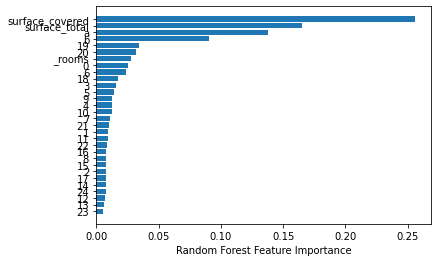

In [207]:
sorted_idx = ran_forest.feature_importances_.argsort()
ran_forest.feature_importances_[sorted_idx]
X_Train.columns = X_Train.columns.astype(str)
plt.barh(X_Train.columns[sorted_idx], ran_forest.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Elegimos dos arboles al azar y vemos si hubo alguna variacion.

Text(0.5, 0, 'Forest  3 - Feature Importance')

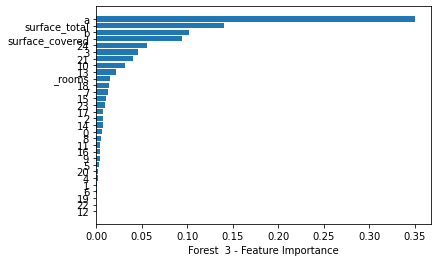

In [208]:
sorted_idx = ran_forest.estimators_[89].feature_importances_.argsort()
plt.barh(X_Train.columns[sorted_idx], ran_forest.estimators_[89].feature_importances_[sorted_idx])
plt.xlabel("Forest  3 - Feature Importance")

Text(0.5, 0, 'Forest  3 - Feature Importance')

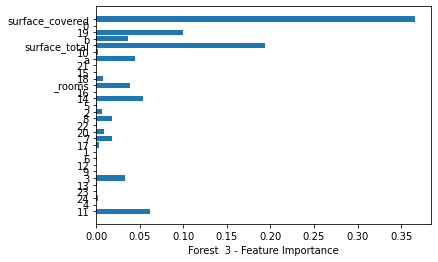

In [209]:
sorted_idx = ran_forest.estimators_[6].feature_importances_.argsort()
plt.barh(X_Train.columns[sorted_idx], ran_forest.estimators_[25].feature_importances_[sorted_idx])
plt.xlabel("Forest  3 - Feature Importance")

Vemos que la feature mas importante para este modelo es surface_total. Tambien se destacan "surface_covered", "Departamento" y la propiedad "a". Obtuvimos la feature 1 cuando hicimos reduccion de dimensionalidad con otras features importantes como bathrooms, bedrooms, y rooms.

Mean Decrease in impurity

#### XGBoost

Text(0.5, 0, 'XgBoost Feature Importance')

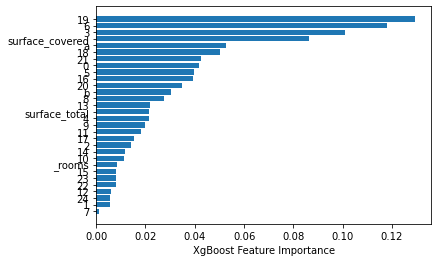

In [210]:
sorted_idx = xgb_model2.feature_importances_.argsort()
plt.barh(X_Train.columns[sorted_idx], xgb_model2.feature_importances_[sorted_idx])
plt.xlabel("XgBoost Feature Importance")

#### Concluciones
* Vemos nuevamente que Departamento, surface_total y surface_covered aparecen como 2 features importantes.
* El mejor resultado es el que obtenemos con XBoost.

In [211]:
#Codigo comentado, problema de performance en esta computadora.

models = ['Decision Tree', 'Random Forest', 'XGBoost']

for i, model in enumerate([d_tree, ran_forest,xgb_model2]):
    for pred_train, y_train_pred in enumerate([train_predict,y_train_pred_f,y_train_pred2_xgb]):
        pred_train = model.predict(X_Train)
        for pred_test, y_test_pred in enumerate([test_predict,y_test_pred_f,y_test_pred2_xgb]): 
            pred_test = model.predict(X_Test)
            for rmse_train in enumerate([train_rmse2,train_rmse2_f, xgb_train_sqrt2]):
                rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
                for rmse_test in enumerate([train_rmse2,test_rmse2_f, xgb_test_sqrt2]):
                    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))    
    
    print(f'Modelo: {models[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (10,6))

    plt.subplot(1,2,1)
    
    a = pred_train.reshape(-1,1)
    b = pred_test.reshape(-1,1)
    sns.distplot(y_train - a, bins = 20, label = 'train')
    sns.distplot(y_test - b, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,pred_test, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

In [212]:
pred_train_tree = d_tree.predict(X_Train)
pred_test_tree = d_tree.predict(X_Test)

In [213]:
rmse_train_tree = np.sqrt(mean_squared_error(y_train,pred_train_tree))
rmse_test_tree = np.sqrt(mean_squared_error(y_test,pred_test_tree))

print("Tree")
print(rmse_train_tree)
print(rmse_test_tree)

Tree
103899.3466362146
124395.26693471635


In [214]:
pred_train_ran_forest = ran_forest.predict(X_Train)
pred_test_ran_forest = ran_forest.predict(X_Test)

In [215]:
rmse_train_ran_forest = np.sqrt(mean_squared_error(y_train,pred_train_ran_forest))
rmse_test_ran_forest = np.sqrt(mean_squared_error(y_test,pred_test_ran_forest))

print("Random forest")
print(rmse_train_ran_forest)
print(rmse_test_ran_forest)

Random forest
125047.36952926267
120977.42141325948


In [216]:
pred_train_xgboost = xgb_model2.predict(X_Train)
pred_test_xgboost = xgb_model2.predict(X_Test)

In [217]:
rmse_train_hgb = np.sqrt(mean_squared_error(y_train,pred_train_xgboost))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test,pred_test_xgboost))

print("XGBoost")
print(rmse_train_hgb)
print(rmse_test_xgb)

XGBoost
105006.04307974089
111135.8773309198


De los resultados obtenidos, notamos que el modelo que mejor trabaja es el XGBoost. Ademas presenta poca variancia, al igual que Random forest. En el modelo de arbol de decision, vemos que ademas de arrojar peores resultados, la diferencia entre Test y Train es mayor.

#### Mejoras
- Pienso que se podria trabajar un poco mas, el procesamiento de los datos. 

    * Agregaría una variable que contemple el precio del dolar al momento de publicar la propiedad. Si el dolar esta en alza o en baja modifica las espectativas en el mercado inmobiliario.

    * Analizaria las descripciones, en cada propiedad, con el objetivo de llenar aquellos datos que son nulos para las superficies, dado que es informacion que se suele incluir en descripciones.

